In [52]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from os import path
import matplotlib.pylab as plt

from dual_controller_model_figures.plot import plot_functions as pf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
repo_path = path.abspath('.')

# output path for the plots
out_path = path.join(repo_path, 'output_plots')

# read the data
dual_model_file = path.join(repo_path, 'data/Intact_reward_100trails_1000timesteps.csv')
rpe_model_file = path.join(repo_path, 'data/NoTail_reward_100trails_1000timesteps.csv')
ape_model_file = path.join(repo_path, 'data/NoDorsal_reward_100trails_1000timesteps.csv')

dual_model = pd.read_csv(dual_model_file, header=None).to_numpy()
rpe_model = pd.read_csv(rpe_model_file, header=None).to_numpy()
ape_model = pd.read_csv(ape_model_file, header=None).to_numpy()

In [54]:
# cut the number of trials and adjust performance to 100
max_trials = 300
dual_model = np.array([100 * x[0:max_trials] for x in dual_model])
ape_model = np.array([100 * x[0:max_trials] for x in ape_model])
rpe_model = np.array([100 * x[0:max_trials] for x in rpe_model])

In [55]:
# rescale to match the 5000 experimental data
exp_data_ntrials = 5000
rescale_factor = int(np.ceil(exp_data_ntrials / max_trials))

xs = np.arange(0, max_trials)*rescale_factor

/tmp/ipykernel_3076088/2207887761.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()


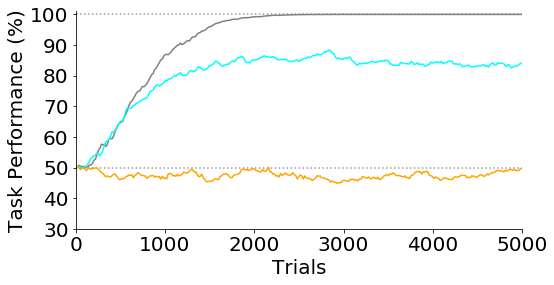

In [56]:
# continous monitoring of learning
fig1 = pf.make_figure_learning_across_trials(dual_model, rpe_model, ape_model, xs, show_std=False)
fig1.show()

# TODO: add vertical lines for when we do innactivations

plt.savefig(path.join(out_path, 'Performance_between_groups.pdf'),
            transparent=True, bbox_inches='tight')

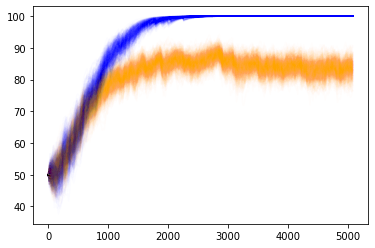

In [57]:
# there are some weird irregularities in the datasets:
# all the agents behave similar overall
dms = dual_model.copy()
rms = rpe_model.copy()
for i in range(500):
    np.random.shuffle(dms)
    np.random.shuffle(rms)
    plt.plot(xs, np.mean(dms[0:10, ], axis=0), color='blue', alpha=.01)
    plt.plot(xs, np.mean(rms[0:10, ], axis=0), color='orange', alpha=.01)

In [238]:
# Subselect X agents to match experimental
n_agents = 12

dms = dual_model.copy()
rms = rpe_model.copy()

np.random.shuffle(dms)
dms = dms[0:n_agents, ]
np.random.shuffle(rms)
rms = rms[0:n_agents, ]


In [239]:
def create_averages_by_window(nparray, windowsize):
    # size of array
    arrsize = len(nparray)
    # iterations
    iterstodo = int(np.floor(arrsize / windowsize))
    # define new array to store data
    arrtoreturn = np.empty(iterstodo)
    # loop
    for i in range(iterstodo):
        idxtostart = i * windowsize
        arrtoreturn[i] = np.mean(nparray[idxtostart:(idxtostart+windowsize)])
    
    return arrtoreturn

In [240]:
# bin trials as in the experimental
# The experiental datasets have 5000 trials and are binned every 100
# so 50 samples
nbins = 50
# average window
avg_window = int(np.floor(max_trials / nbins))
# empty lists to store values
dmsbin = []
rmsbin = []
# loop
for i in range(dms.shape[0]):
    dmsbin.append(create_averages_by_window(dms[i], avg_window))
    rmsbin.append(create_averages_by_window(rms[i], avg_window))

dmsbin = np.array(dmsbin)
rmsbin = np.array(rmsbin)

In [241]:
# calculate the differences between the models
model_diffs = np.mean(dmsbin, axis=0) - np.mean(rmsbin, axis=0)

In [242]:
# create shuffles of the data and calculate the
# differences of the means. Create a shuffled array of means
n_times = 1000
rows, cols = dmsbin.shape
shuffled_arr = np.empty([n_times, cols])
# mix both models
mixed = np.concatenate([dmsbin, rmsbin])
for i in range(n_times):
    # shuffle and split in half
    np.random.shuffle(mixed)
    mean1 = np.mean(mixed[0:rows, ], axis=0)
    mean2 = np.mean(mixed[rows:, ], axis=0)
    shuffled_arr[i, :] = mean1 - mean2

In [243]:
# calculate confidence intervals
top_ci = np.quantile(shuffled_arr, .95, axis=0)
bot_ci = np.quantile(shuffled_arr, .05, axis=0)

In [244]:
# # TODO: bring back the experimental results
# import pickle
# file = open('/home/hernandom/Desktop/figure_chronic-lesions.mpl', 'rb')
# figure = pickle.load(file)
# figure.show()

/tmp/ipykernel_3076088/3233245424.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


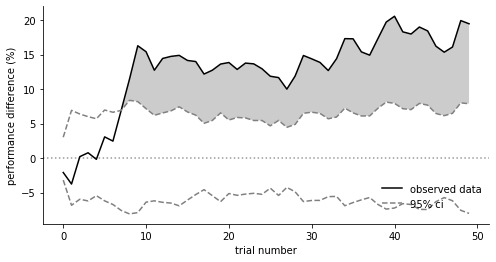

In [245]:
# plot
xsbin = range(dmsbin.shape[1])
fig2 = plt.figure(figsize=(8, 4))
plt.axhline(0, ls='dotted', alpha=0.4, color='k')
plt.plot(xsbin, model_diffs, color='k', label='observed data')
plt.plot(xsbin, top_ci, linestyle='--', color='gray', label='95% ci')
plt.plot(xsbin, bot_ci, linestyle='--', color='gray')
plt.fill_between(xsbin, top_ci, model_diffs, where=model_diffs >= top_ci,
                 facecolor='k', alpha=.2, interpolate=True)
plt.ylabel('performance difference (%)')
plt.xlabel('trial number')
plt.legend(loc=(0.75, 0.05), frameon=False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlim((0,5000))

plt.savefig(path.join(out_path, 'Differences_of_means_significance.pdf')
            ,transparent=True, bbox_inches='tight')
fig2.show()

### Plot the weights

In [60]:
# read data for the weights
tail_weights_file = path.join(repo_path, 'data/Intact_4weight_tail_100trails_1000timesteps.csv')
critic_weights_file = path.join(repo_path, 'data/Intact_4weight_critic_1000timesteps.csv')
actor_weights_file = path.join(repo_path, 'data/Intact_4weight_actor_1000timesteps.csv')

tailw = pd.read_csv(tail_weights_file, header=None).to_numpy()
criticw = pd.read_csv(critic_weights_file, header=None).to_numpy()
actorw = pd.read_csv(actor_weights_file, header=None).to_numpy()

In [88]:
# the data has 100 agents in it. Calculate the mean using an average of 100 (because of the weird data structure)
# empty lists to store values
tailwm = []
criticwm = []
actorwm = []
# loop
for i in range(tailw.shape[0]):
    tailwm.append(create_averages_by_window(tailw[i], 100))
    criticwm.append(create_averages_by_window(criticw[i], 100))
    actorwm.append(create_averages_by_window(actorw[i], 100))

tailwm = np.array(tailwm)
criticwm = np.array(criticwm)
actorwm = np.array(actorwm)


/tmp/ipykernel_3076088/1577359329.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


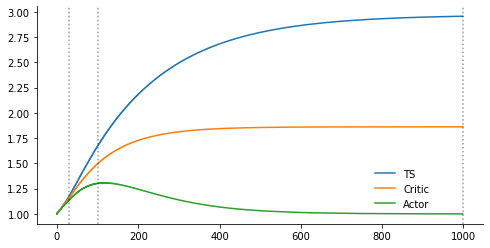

In [182]:
# plot the first weight of each
agents = [tailwm, criticwm, actorwm]
labels = ['TS', 'Critic', 'Actor']
innact_times  = [30, 100, 1000]
fig3 = plt.figure(figsize=(8, 4))
for i, agent in enumerate(agents):
    # correct that the last 100 original values are 0
    plt.plot(agent[0, :-1], label=labels[i])
# innactivation points
for xp in innact_times:
    plt.axvline(xp, ls='dotted', alpha=0.4, color='k')
plt.legend(loc=(0.75, 0.05), frameon=False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.set_xlim((0,5000))

plt.savefig(path.join(out_path, 'Weights.pdf')
            ,transparent=True, bbox_inches='tight')
fig3.show()

/tmp/ipykernel_3076088/1897087937.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig4.show()


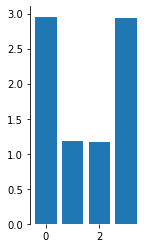

In [190]:
# Figure with the end weights for TS

# same correction as before to get the last weights

dataforbarplot = np.mean(tailw[:, -201:-101], axis=1)

fig4 = plt.figure(figsize=(2, 4))
plt.bar(range(tailw.shape[0]), dataforbarplot)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(path.join(out_path, 'TS_final_weights.pdf')
            ,transparent=True, bbox_inches='tight')
fig4.show()

### Inactivations

In [203]:
# read data for the weights
tail_early_inactivation_file = path.join(repo_path, 'data/Inactivation_Tail_t30_reward_100trails_2000timesteps.csv')
t_early = pd.read_csv(tail_early_inactivation_file, header=None).to_numpy()

tail_mid_inactivation_file = path.join(repo_path, 'data/Inactivation_Tail_t100_reward_100trails_2000timesteps.csv')
t_mid = pd.read_csv(tail_mid_inactivation_file, header=None).to_numpy()

tail_late_inactivation_file = path.join(repo_path, 'data/Inactivation_Tail_t1000_reward_100trails_2000timesteps.csv')
t_late = pd.read_csv(tail_late_inactivation_file, header=None).to_numpy()

dorsal_early_inactivation_file = path.join(repo_path, 'data/Inactivation_Dorsal_t30_reward_100trails_2000timesteps.csv')
d_early = pd.read_csv(dorsal_early_inactivation_file, header=None).to_numpy()

dorsal_mid_inactivation_file = path.join(repo_path, 'data/Inactivation_Dorsal_t100_reward_100trails_2000timesteps.csv')
d_mid = pd.read_csv(dorsal_mid_inactivation_file, header=None).to_numpy()

dorsal_late_inactivation_file = path.join(repo_path, 'data/Inactivation_Dorsal_t1000_reward_100trails_2000timesteps.csv')
d_late = pd.read_csv(dorsal_late_inactivation_file, header=None).to_numpy()

In [319]:
# quantify performance before and after inactivations as the mean of the previous / following X trials
x_tr_before = 1
spacer_trials = 10
x_tr_after = 700

# inactivation times
early_in_time = 30
mid_in_time = 100
late_in_time = 1000

intact_early_perf = 100 * np.mean(np.mean(d_early, axis=0)[(early_in_time - x_tr_before - 1):(early_in_time - 1)])
tail_early_perf = 100 * np.mean(np.mean(t_early, axis=0)[(early_in_time + spacer_trials):(early_in_time + spacer_trials + x_tr_after)])
dorsal_early_perf = 100 * np.mean(np.mean(d_early, axis=0)[(early_in_time + spacer_trials):(early_in_time + spacer_trials + x_tr_after)])

intact_mid_perf = 100 * np.mean(np.mean(d_mid, axis=0)[(mid_in_time - x_tr_before - 1):(mid_in_time - 1)])
tail_mid_perf = 100 * np.mean(np.mean(t_mid, axis=0)[(mid_in_time + spacer_trials):(mid_in_time + spacer_trials + x_tr_after)])
dorsal_mid_perf = 100 * np.mean(np.mean(d_mid, axis=0)[(mid_in_time + spacer_trials):(mid_in_time + spacer_trials + x_tr_after)])

intact_late_perf = 100 * np.mean(np.mean(d_late, axis=0)[(late_in_time - x_tr_before - 1):(late_in_time - 1)])
tail_late_perf = 100 * np.mean(np.mean(t_late, axis=0)[(late_in_time + spacer_trials):(late_in_time + spacer_trials + x_tr_after)])
dorsal_late_perf = 100 * np.mean(np.mean(d_late, axis=0)[(late_in_time + spacer_trials):(late_in_time + spacer_trials + x_tr_after)])

In [320]:
# define the data for the plot
dataforbarplot = [intact_early_perf, dorsal_early_perf, tail_early_perf,
                  intact_mid_perf, dorsal_mid_perf, tail_mid_perf,
                  intact_late_perf, dorsal_late_perf, tail_late_perf]

# spacing of bars
xs = [0,1,2,4,5,6,8,9,10]

# colors
cols = ['k', 'g', 'r'] * 3


/tmp/ipykernel_3076088/1893980320.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig5.show()


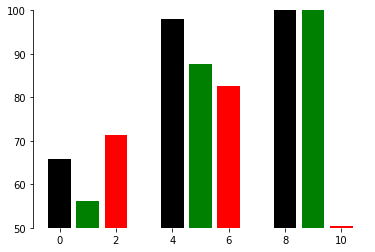

In [321]:
fig5 = plt.figure(figsize=(6, 4))
plt.bar(xs, dataforbarplot, color=cols)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(50,100)
plt.savefig(path.join(out_path, 'Inactivations.pdf')
            ,transparent=True, bbox_inches='tight')
fig5.show()

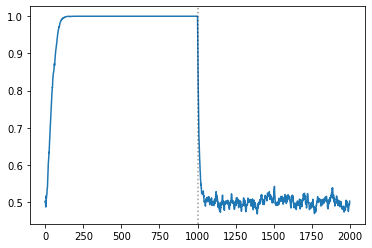

In [322]:
plt.plot(np.mean(t_late, axis=0))
plt.axvline(1000, ls='dotted', alpha=0.4, color='k')

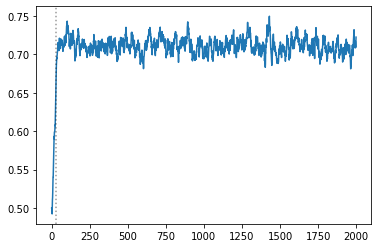

In [318]:
plt.plot(np.mean(t_early, axis=0))
plt.axvline(30, ls='dotted', alpha=0.4, color='k')

(20, 50)

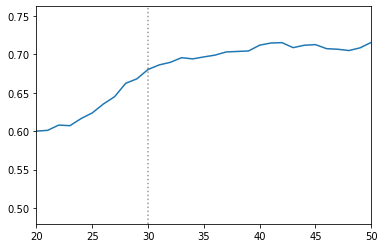

In [317]:
plt.plot(np.mean(t_early, axis=0))
plt.axvline(30, ls='dotted', alpha=0.4, color='k')
plt.gca().set_xlim(20,50)

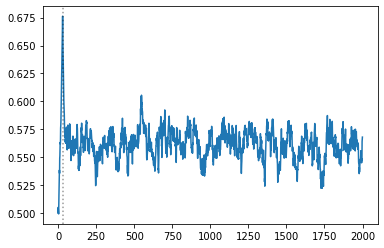

In [315]:
plt.plot(np.mean(d_early, axis=0))
plt.axvline(30, ls='dotted', alpha=0.4, color='k')
# plt.gca().set_xlim(20,40)

In [ ]:
# # do this several times to see how the randomness behaves
# n_agents = 10

# for i in range(50):
#     dms = dual_model.copy()
#     rms = rpe_model.copy()

#     np.random.shuffle(dms)
#     dms = dms[0:n_agents, ]
#     np.random.shuffle(rms)
#     rms = rms[0:n_agents, ]
#     # plot differences
#     model_diffs = np.mean(dms, axis=0) - np.mean(rms, axis=0)
#     plt.plot(xs, model_diffs, alpha=.1, color='k')
# plt.show()